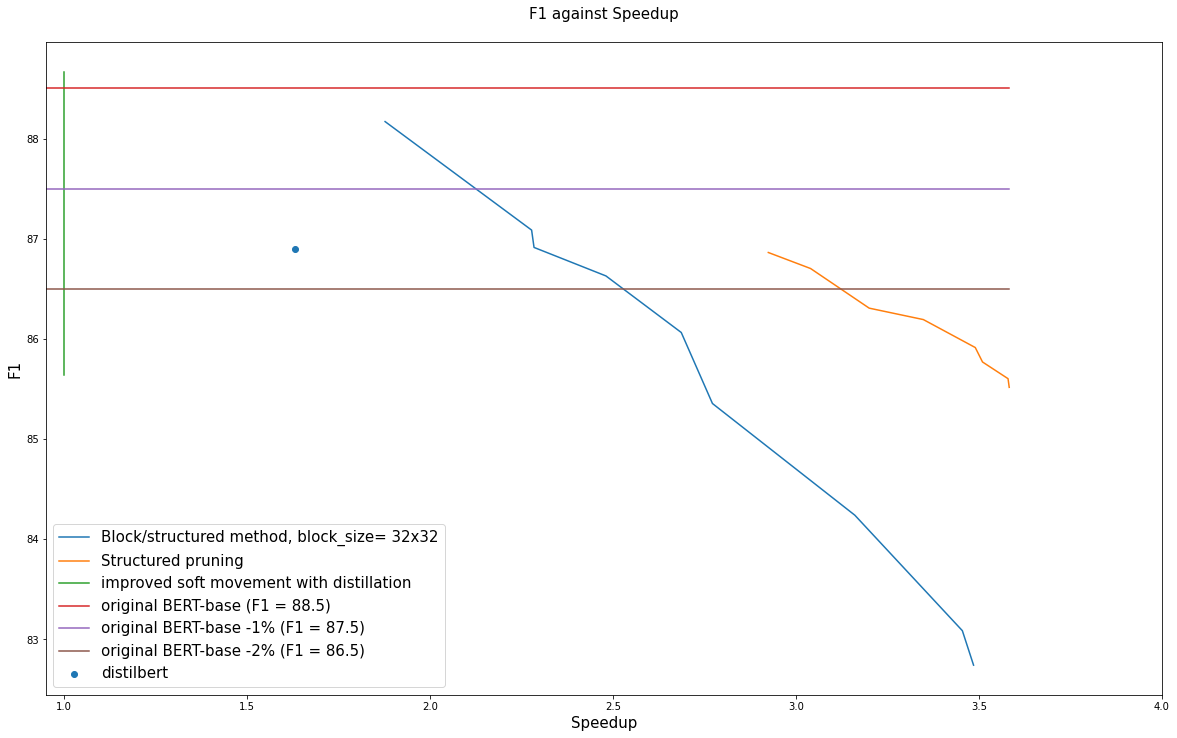

In [158]:
import pandas
import math
import numpy
from matplotlib import pyplot as pyplot
import os
import json
from pathlib import Path

#%matplotlib widget

class Plotter():
    def __init__(self, filename):
        self.filename = filename
        
    def read_checkpoint_info(self):
        j = json.load(open(self.filename))

        base_time = j["base_speed_report"]["eval_elapsed_time"]

        points = []
        max_speedup = 1.0
        for name, checkpoint in j["checkpoints"].items():
            
            try:
                #print(name, list(checkpoint.keys()))
                speedup = base_time / checkpoint["speed"]["eval_elapsed_time"]
                speedup = max(1.0, speedup)
            except:
                speedup = 1.0
            max_speedup=max(max_speedup, speedup)
            p = Path(name)
            eval_metrics = checkpoint.get("opt_eval_metrics")
            if eval_metrics is None or True:
                eval_metrics = json.load(open(p / "eval_metrics.json"))
            
            sparsity_report = json.load(open(p / "sparsity_report.json"))
            sparsity = 1.0 - (sparsity_report["linear_nnz"] / sparsity_report["linear_total"])
            sparse_args = json.load(open(p / "sparse_args.json"))
            
            
            point = dict(speedup=speedup, **eval_metrics, sparsity=sparsity, sparse_args=sparse_args, path=name)
            points.append(point)
            
            
            
        return points

    def model_part_size(self, model_name, white_list, black_list):
        from transformers import AutoModelForQuestionAnswering
        from pytorch_block_sparse import BlockSparseModelPatcher

        model = AutoModelForQuestionAnswering.from_pretrained(model_name)

        a = {k:v for k,v in model.named_parameters()}
        total = 0
        for k,v in a.items():
            def check(x):            
                for bl in black_list:
                    if bl in x:
                        return False
                for wl in white_list:
                    if wl not in x:
                        return False
                return True
            if not check(k):
                continue

            total += v.numel()
        return total
    
    def distilbert_data(self):
        path = Path("distilbert_info.json")
        if path.exists():
            return json.load(path.open())
        total_distilbert = self.model_part_size("distilbert-base-uncased-distilled-squad",
                                                white_list=["weight"],
                                                black_list=["embeddings", "layer_norm", "qa"])
        
        total_bert = self.model_part_size("csarron/bert-base-uncased-squad-v1",
                                          white_list=["weight"],
                                          black_list=["embeddings", "LayerNorm", "qa"])
                    
        # From https://arxiv.org/pdf/1910.01108.pdf
        d = [{"f1":86.9, "exact": 79.1, "fill_rate": total_distilbert / total_bert, "speedup": 1.63}]
        
        json.dump(d, path.open("w"))
        
        return d
    
    def read_reference_entries(self):
        defaults = dict(size=1, inner_sparsity=1, cols=1, rows=1, epochs=10)
        ret = dict(local_movement_pruning=[], soft_movement_with_distillation=[])
    
        xcel_file_name = "/home/lagunas/devel/hf/block_movement_pruning/notebooks/mvmt_pruning.xlsx"
        xcel = pandas.read_excel(xcel_file_name, index_col=0, sheet_name="Details - SQuAD")  
        xcel = pandas.DataFrame(xcel)
        for i, (r, d) in enumerate(xcel.iterrows()):
            if i > 2:
                if str(d[2]) != "nan":
                    name = d[2]
                    name_parts = name.split("_")
                    if name.startswith("topK_1.0"):
                        key = "local_movement_pruning"
                    elif name.startswith("l1_with_distil"):
                        key = "soft_movement_with_distillation"
                    else:
                        key = None
                    if key != None:
                        d = dict(name=name, fill_rate= d[3] / 100.0, exact=d[4], f1=d[5])

                        d.update(defaults)
                        ret[key].append(d)
                        
        
        # Add other networks
        ret["distilbert"] = self.distilbert_data()
        
        return ret

    def check(self, d, equals, not_equals):
        for k,v in equals.items():
            if d[k] != v:
                #print(f"d[{k}]={d[k]} !={v}")
                return False
        for k,v in not_equals.items():
            if d[k] == v:
                return False
        return True
            
    def is_new_xp(self, xp):
        compare = dict(attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
                
        compare_different=dict(attention_block_cols = 1,
                               attention_block_rows = 1,                       
                               distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            cols = sparse_args['attention_block_cols']
            rows = sparse_args['attention_block_rows']
            #if cols == 768:
            #    return None
            if cols == 768:
                ret = "Structured pruning"
            else:
                ret = f"Block/structured method, block_size= {rows}x{cols}"
            annotate = f"l="+ str(sparse_args['regularization_final_lambda'])
            annotate += ", al=" + str(sparse_args.get('attention_lambda', "1.0"))
            annotate += ", ver=" + str(0 if sparse_args.get('attention_output_with_dense', True) else 1)
            return ret, annotate
        else:
            return None, None
    
    def is_improved_mvmt_pruning(self, xp):
        compare = dict(attention_block_cols = 1,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,    
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)
        
        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "improved soft movement with distillation"
        else:
            return None

    
    def is_longer_final_warmup(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=15,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, longer final warmup (15 instead of 10)"
        else:
            return None
        
    def is_attention_rows(self, xp):
        compare = dict(attention_block_cols = 768,
                       attention_block_rows = 1,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 1,
                       dense_block_rows = 1,
                       dense_pruning_method='sigmoied_threshold:1d_alt',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "new method, attention pruned with rows"
        else:
            return None
        
    def is_block_sparse(self, xp):
        compare = dict(attention_block_cols = 32,
                       attention_block_rows = 32,
                       attention_pruning_method = 'sigmoied_threshold',
                       dense_block_cols = 32,
                       dense_block_rows = 32,
                       dense_pruning_method='sigmoied_threshold',
                       initial_warmup=1,
                       final_warmup=10,
                       regularization="l1")
        
        compare_different=dict(distil_teacher_name_or_path=None)

        sparse_args = xp["sparse_args"]
        if self.check(sparse_args, compare, compare_different):
            return "block_sparse"
        else:
            return None
                                                                                
    
    def categorize(self, xp):
        checkpoint_index = int(xp["path"].split("/")[-1].split("-")[-1])
        if checkpoint_index <= 75000:
            return "small_epoch", ""        
                
        new_xp, annotate = self.is_new_xp(xp)
        if new_xp:
            return new_xp, annotate
        annotate = ""
        improved_mvmt_pruning = self.is_improved_mvmt_pruning(xp)
        if improved_mvmt_pruning:
            return improved_mvmt_pruning, annotate
        
        longer_warmup = self.is_longer_final_warmup(xp)
        if longer_warmup:
            return longer_warmup, annotate
        
        attention_rows = self.is_attention_rows(xp)
        if attention_rows:
            return attention_rows, annotate  
        
        block_sparse = self.is_block_sparse(xp)
        if block_sparse:
            return block_sparse, annotate
        
        return "misc", annotate
    
    def process_checkpoint(self, checkpoint):
        d = checkpoint
        ret = dict(fill_rate=1.0 - d["sparsity"], f1=d["f1"])
        
        speedup = d["speedup"]
        if speedup > 1:
            ret["speedup"] = speedup
        return ret
    
    def checkpoints_prepare(self, checkpoints):
        ret = {}
        for checkpoint in checkpoints:
            cat, annotate = self.categorize(checkpoint)
            if cat == None:
                continue
            if cat not in ret:
                ret[cat] = []
            processed = self.process_checkpoint(checkpoint)
            processed["annotate"] = annotate
            processed["path"] = checkpoint["path"]
            #if cat == "misc":
            #    print(json.dumps(checkpoint["sparse_args"], indent=4))
            ret[cat].append(processed)
        return ret
    
    def filter_checkpoints(self, checkpoints, key="speedup"):
        if key == "fill_rate":
            sgn = -1
        else:
            sgn = 1
        sort_by_key = lambda x : sgn * x.get(key, 1.0)
        checkpoints.sort(key = sort_by_key, reverse = True)
        best_c = checkpoints[0]
        
        filtered_checkpoints = [best_c]
        for checkpoint in checkpoints[1:]:
            if checkpoint["f1"] > filtered_checkpoints[-1]["f1"]:
                filtered_checkpoints.append(checkpoint)
        
        
        filtered_checkpoints.sort(key=sort_by_key, reverse = False)
        
        return filtered_checkpoints
    
   
                        
    def plot(self):
        checkpoints = self.read_checkpoint_info()

        reference_entries = self.read_reference_entries()
        
        labels = []
        parts = []
        reference_black_list = ["local_movement_pruning", "soft_movement_with_distillation"]
        for k,v in reference_entries.items():
            if k in reference_black_list:                
                continue
            labels.append(k)
            parts.append(v)
        
        checkpoints_plot_info = self.checkpoints_prepare(checkpoints)
                
        category_keys = list(checkpoints_plot_info.keys())
        category_keys.sort()

        
        key = "speedup"
        #key = "fill_rate"


        white_list = ['improved soft movement with distillation', "Structured pruning", "Block/structured method, block_size= 32x32", 'new xp, block_size= 64x768'] #, 'new xp, block_size= 16x16']
        #white_list = None
        if key == "speedup":
            legend_loc = 'lower left'
            x_min = 0.95 ##2.0
            x_max = 4.0
        else:
            legend_loc = 'lower right'
            x_min = 0.0
            x_max = 0.5
            
        y_min = None#85.0
        y_max = 88.0
        draw_labels = False
        fontsize = 15

        
    #    select = ['block_sparse', 'improved soft movement with distillation', 'misc', 'new method, attention pruned with rows', 'new method, longer final warmup (15 instead of 10)', 'new xp, block_size= 16x16', 'new xp, block_size= 32x32', 'new xp, block_size= 64x32', 'small_epoch']
        black_list = ["small_epoch", 'new method, attention pruned with rows']
        
#        white_list = None
        
        for k in category_keys:
            if white_list is not None and k not in white_list:
                continue
            if k in black_list:         
                continue
            v = checkpoints_plot_info[k]
            labels.append(k)
            parts.append(v)
        
        
        markers = ["o", "v", "s", "+", "v"]

        fig = pyplot.figure(figsize=(20,12))
        ax1 = fig.add_subplot(111)
        max_x = 0
        

        
        for i, data in enumerate(parts):
            label = labels[i]
            data = self.filter_checkpoints(data, key = key)
                        
            x = [e.get(key, 1.0) for e in data]
            max_x = max(max_x, max(x))
            y = [e["f1"] for e in data]
        
            if len(x) == 1:
                pyplot.scatter(x, y, cmap='viridis', alpha=1.0, label = label) #, marker=markers[i]) # cool
            else:
                pyplot.plot(x, y, label = labels[i]) #, marker=markers[i]) # cool
            
            if draw_labels:
                try:
                    for i, txt in enumerate(x):
                        if x_min is None or x[i] >= x_min and x[i] <= x_max:
                            if y_min is None or y[i] >= y_min and y[i] <= y_max:
                                ax1.annotate(data[i].get("annotate", ""), (x[i]+0.005, y[i]+0.005))
                except Exception as e:
                    print(e)
                    pass
            
        for i in range(3):
            f1 = 88.5 - i
            pyplot.plot([0,max_x], [88.5 - i] * 2, label=f"original BERT-base {'' if i == 0 else str(-i)+'% '}(F1 = {f1})")
        
        
        pyplot.legend(loc=legend_loc, prop={'size': fontsize})
        #pyplot.xscale('log')
        
        if x_min != None:
            pyplot.xlim(x_min, x_max)
        if y_min != None:
            pyplot.ylim(y_min, y_max)
        XLabel = key.replace("_", " ").capitalize()
        pyplot.xlabel(XLabel, fontsize=fontsize)
        YLabel = "F1"
        pyplot.ylabel(YLabel, fontsize=fontsize)
        title = '%s against %s\n' % (YLabel, XLabel)
        pyplot.title(title, fontsize=fontsize)
        
       
        
p = Plotter("results4.json")
p.plot()




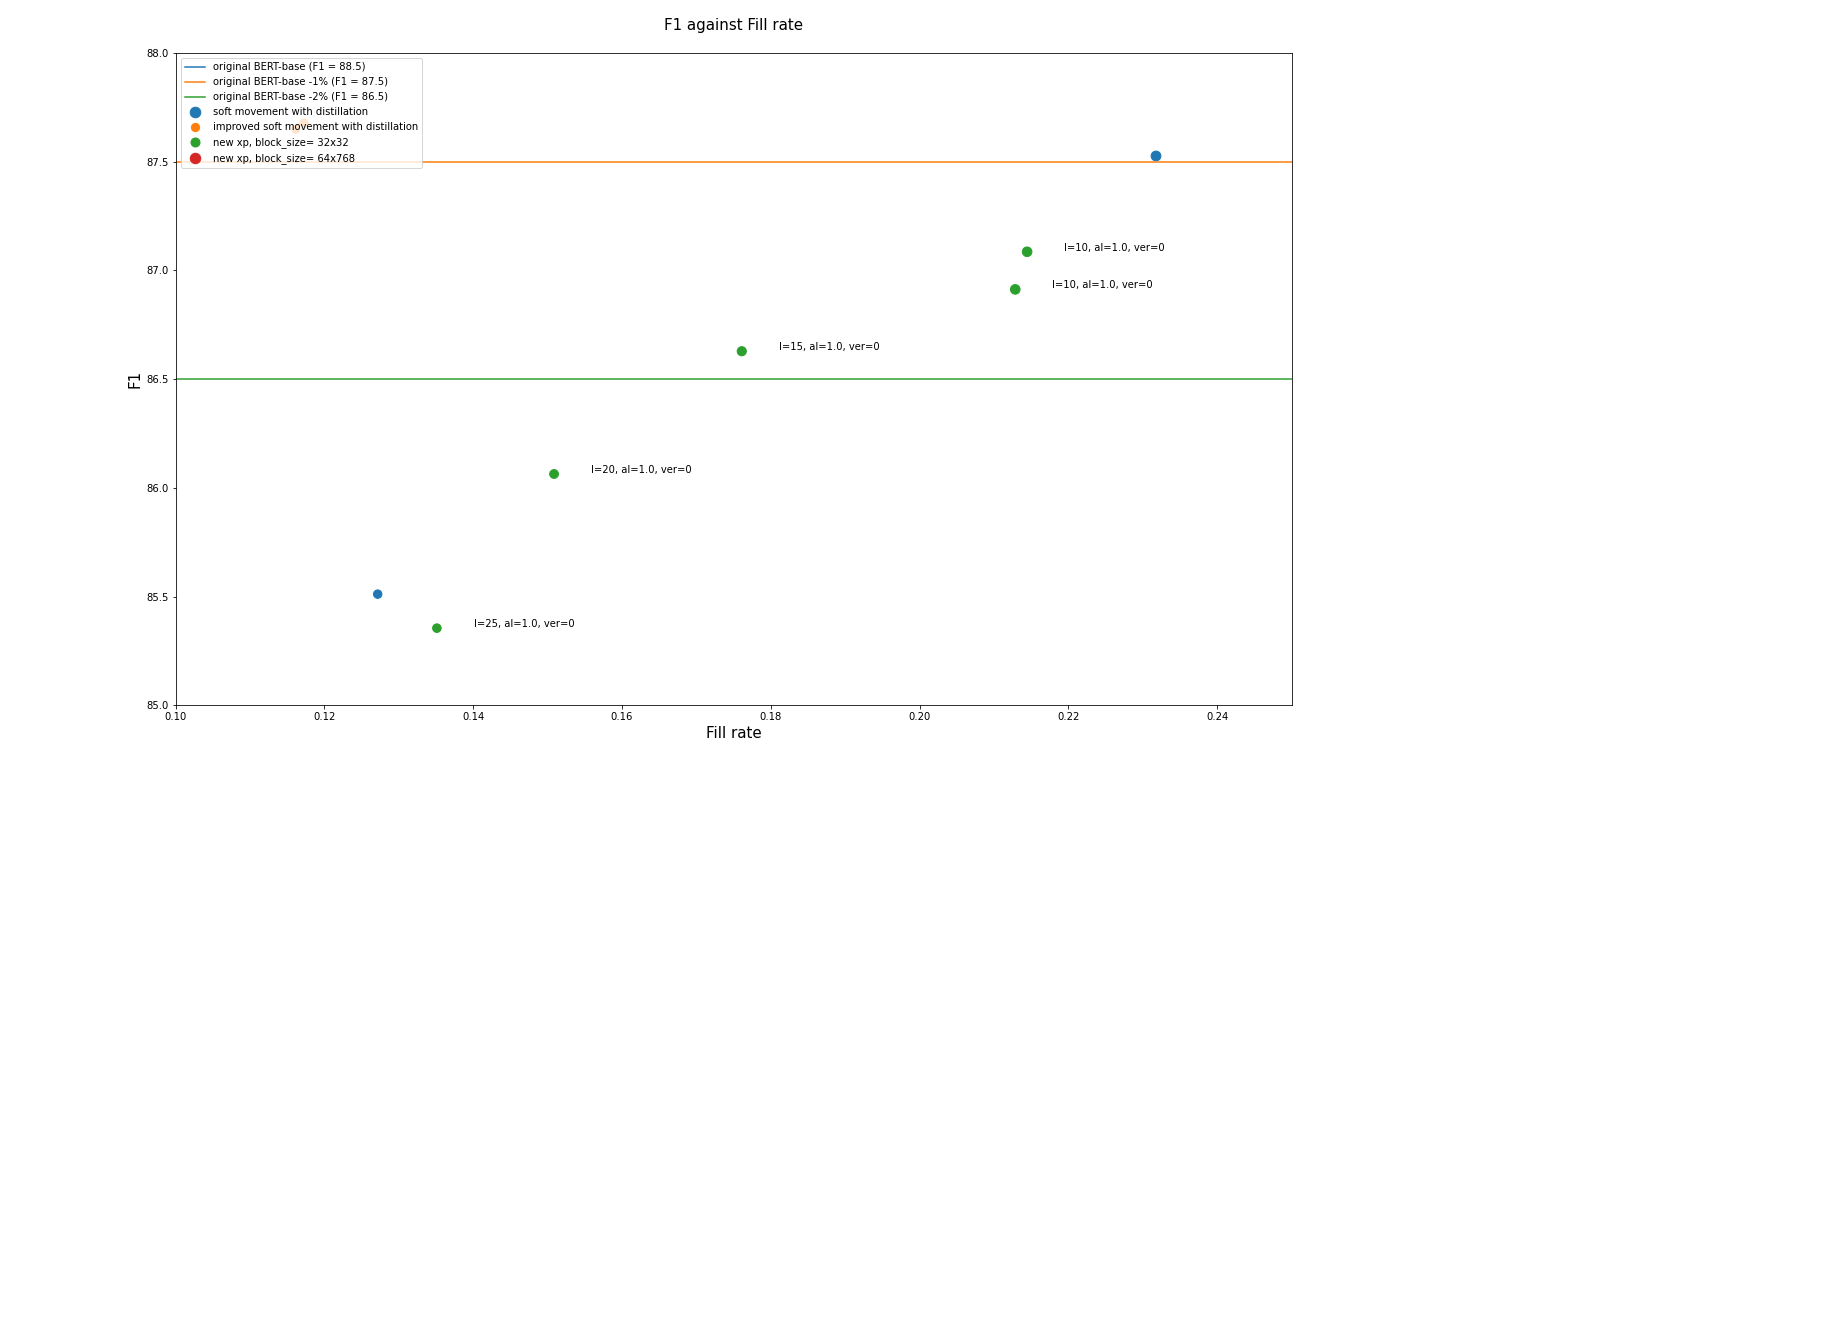

In [2]:
        
p = Plotter("results.json")
p.plot()

In [97]:
if False:
    import nn_pruning.examples.question_answering.qa_sparse_xp as qa_sparse_xp
    src_path = "/data_2to/devel_data/nn_pruning/output/squad_test3/hp_od-output__squad_test3_es-steps_nte20_ls250_est5000_rn-output__squad_test3_dpm-sigmoied_threshold:1d_alt_apme-sigmoied_threshold_aowd0_it0_fw10_r-l1_rfl10.0_al0.00156_dtnop-csarron__bert-base-uncased-squad-v1/checkpoint-90000"
    dest_path = "/home/lagunas/devel/hf/models/madlag/bert-base-uncased-squad1.1-pruned-x3.2-v2"
    qa_sparse_xp.QASparseXP.compile_model(src_path, dest_path = dest_path)